# Makine Öğrenmesi ile Spam Sınıflandırması

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as mt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv("./resources/SMSSpamCollection.csv")
df = data.copy()
df.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


# Veri Setini Tanıma

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  5574 non-null   object
 1   label    5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.describe()

,message,label
count,5574,5574
unique,5171,2
top,"Sorry, I'll call later",ham
freq,30,4827


In [5]:
df = df.rename(columns={"message":"text"})

In [6]:
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4827   4518                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

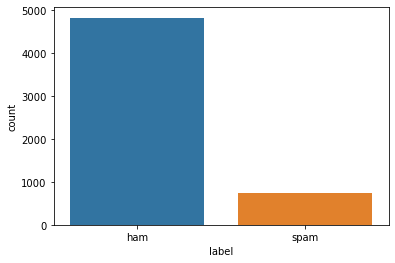

In [7]:
sns.countplot(x="label", data=df);

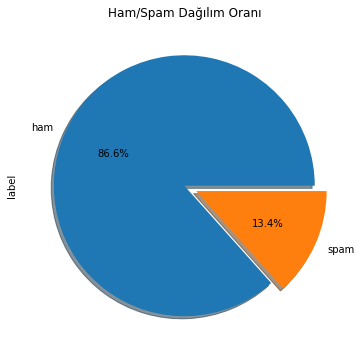

In [8]:
df["label"].value_counts().plot.pie(autopct='%1.1f%%', explode = [0, 0.1], figsize = (6, 6),shadow = True);
plt.title("Ham/Spam Dağılım Oranı");

# Matematiksel İşlemler ve Basit Özellik Çıkarımı

## a. Harf/Karakter Sayısı

In [9]:
x_df = df.copy()

In [10]:
x_df["text"].str.len()

0       111
1        29
2       155
3        49
4        61
       ... 
5569    161
5570     37
5571     57
5572    125
5573     26
Name: text, Length: 5574, dtype: int64

In [11]:
x_df["harf_sayisi"] = x_df["text"].str.len()
x_df.head()

,text,label,harf_sayisi
0,"Go until jurong point, crazy.. Available only ...",ham,111
1,Ok lar... Joking wif u oni...,ham,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155
3,U dun say so early hor... U c already then say...,ham,49
4,"Nah I don't think he goes to usf, he lives aro...",ham,61


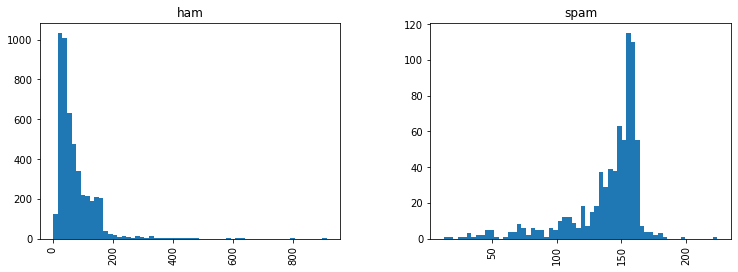

In [12]:
x_df.hist(column='harf_sayisi',by='label',bins=60,figsize=(12,4));

## b. Kelime Sayısı

In [13]:
x_df["kelime_sayisi"] = x_df["text"].apply(lambda x:len(str(x).split(" ")))
x_df.head()

,text,label,harf_sayisi,kelime_sayisi
0,"Go until jurong point, crazy.. Available only ...",ham,111,20
1,Ok lar... Joking wif u oni...,ham,29,6
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155,28
3,U dun say so early hor... U c already then say...,ham,49,11
4,"Nah I don't think he goes to usf, he lives aro...",ham,61,13


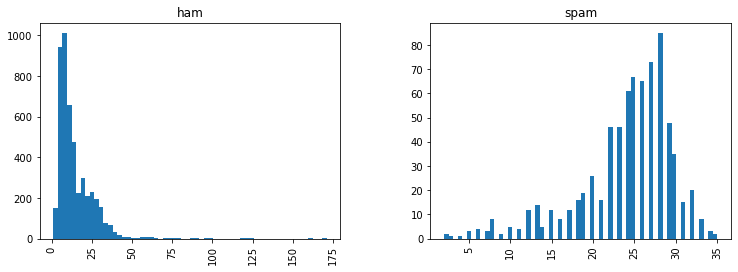

In [14]:
x_df.hist(column='kelime_sayisi',by='label',bins=60,figsize=(12,4));

## c. Sayilari Yakalamak & Saydirmak

In [15]:
x_df["sayi_sayisi"] = data["message"].apply(lambda x: len([x for x in x.split()
                                      if x.isdigit()]))

In [16]:
x_df.head()

,text,label,harf_sayisi,kelime_sayisi,sayi_sayisi
0,"Go until jurong point, crazy.. Available only ...",ham,111,20,0
1,Ok lar... Joking wif u oni...,ham,29,6,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155,28,2
3,U dun say so early hor... U c already then say...,ham,49,11,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,61,13,0


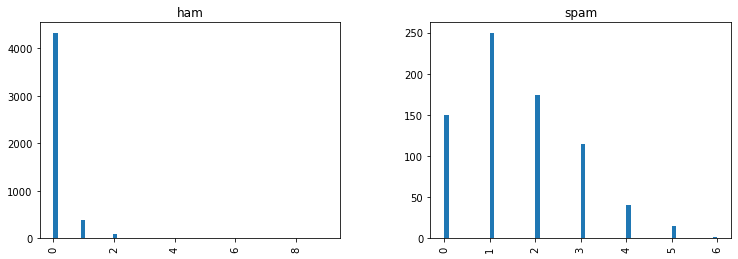

In [17]:
x_df.hist(column='sayi_sayisi',by='label',bins=60,figsize=(12,4));

In [18]:
x_df.describe().T

,count,mean,std,min,25%,50%,75%,max
harf_sayisi,5574.0,80.604593,59.919970,2.0,36.0,62.0,122.0,910.0
kelime_sayisi,5574.0,15.704162,11.482682,1.0,7.0,12.0,23.0,171.0
sayi_sayisi,5574.0,0.330283,0.801370,0.0,0.0,0.0,0.0,9.0


<Figure size 864x576 with 0 Axes>

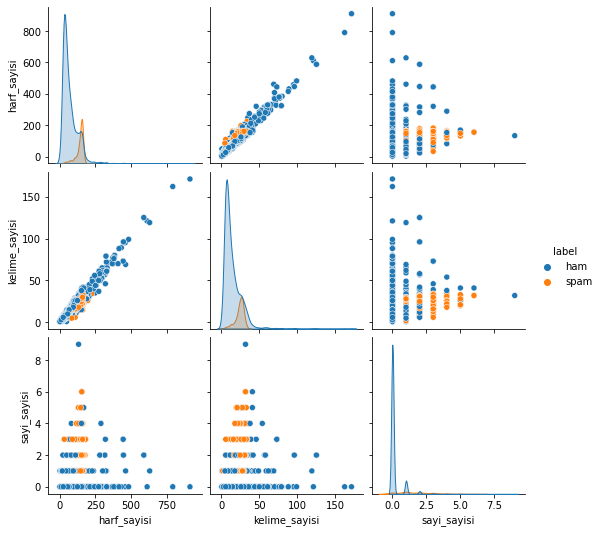

In [19]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=x_df, hue="label")
plt.show(fg)

## Metin Ön İşleme

### Özel Karakterlerin Ayrımı

In [20]:
for i in range(len(df)):
    df["text"][i] = re.sub('[^a-zA-Z]', ' ', df["text"][i])
    
df.head()

,text,label
0,Go until jurong point crazy Available only ...,ham
1,Ok lar Joking wif u oni,ham
2,Free entry in a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor U c already then say,ham
4,Nah I don t think he goes to usf he lives aro...,ham


### Büyük - Küçük Karakter Dönüşümü

In [21]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head(20)

,text,label
0,go until jurong point crazy available only in ...,ham
1,ok lar joking wif u oni,ham
2,free entry in a wkly comp to win fa cup final ...,spam
3,u dun say so early hor u c already then say,ham
4,nah i don t think he goes to usf he lives arou...,ham
5,freemsg hey there darling it s been week s now...,spam
6,even my brother is not like to speak with me t...,ham
7,as per your request melle melle oru minnaminun...,ham
8,winner as a valued network customer you have b...,spam
9,had your mobile months or more u r entitled to...,spam


### Stop Words 

In [22]:
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [23]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

### Seyrek Bulunan İfadelerin Silinmesi

In [24]:
least = pd.Series(" ".join(df["text"]).split()).value_counts().reset_index()
least.columns = ['words', 'tf']
least.head()

,words,tf
0,u,1228
1,call,608
2,get,397
3,ur,391
4,gt,318


In [25]:
sil = least[least["tf"] < 50]
sil

,words,tf
178,ppm,49
179,heart,49
180,use,49
181,days,49
182,thought,47
...,...,...
7636,shadow,1
7637,breadstick,1
7638,saeed,1
7639,purple,1


In [26]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

### Lemmitization

In [27]:
from textblob import Word
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [28]:
df[15:20]

,text,label
15,xxxmobilemovieclub use credit click wap link n...,spam
16,oh k watching,ham
17,eh u remember spell name yes v naughty make v wet,ham
18,fine way u feel way gota b,ham
19,england v macedonia dont miss goal team news t...,spam


## Terim Frekansı (Terimlerin Kullanım Sıklığı)

In [29]:
tf1 = pd.Series(' '.join(df['text']).lower().split()).value_counts().reset_index()
tf1.columns = ['words', 'tf']

In [30]:
tf1.head()

,words,tf
0,u,1295
1,call,641
2,get,408
3,ur,391
4,gt,318


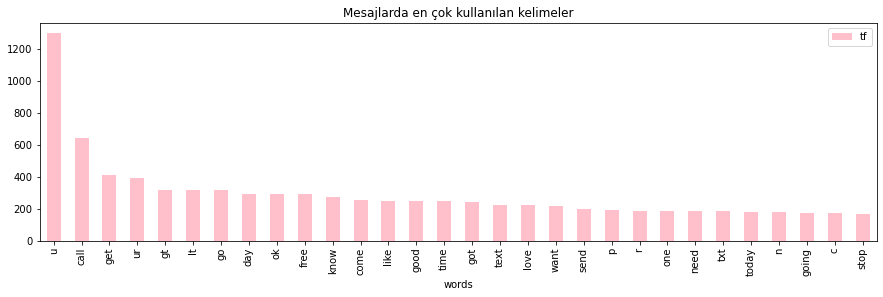

In [31]:
tf1[:30].plot.bar(x="words", y="tf", figsize=(15,4), color="pink");
plt.title('Mesajlarda en çok kullanılan kelimeler');

In [32]:
ham_count = Counter(" ".join(df[df['label']=='ham']["text"]).split()).most_common(30)
ham_count_df = pd.DataFrame(ham_count, columns=["words", "freq"])
print("En çok kullanılan 10 ham kelimesi:")
ham_count_df.head(10)

En çok kullanılan 10 ham kelimesi:


,words,freq
0,u,1100
1,get,322
2,gt,318
3,lt,316
4,ok,288
5,go,283
6,call,253
7,day,251
8,come,249
9,ur,247


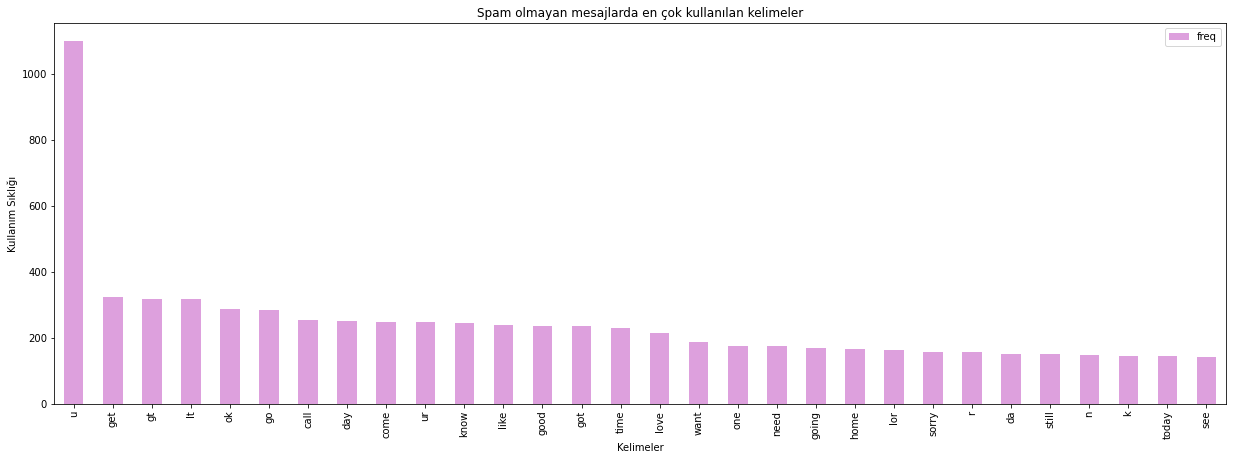

In [33]:
ham_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="plum");
plt.title('Spam olmayan mesajlarda en çok kullanılan kelimeler');
plt.xlabel('Kelimeler')
plt.ylabel('Kullanım Sıklığı');

In [34]:
spam_count = Counter(" ".join(df[df['label']=='spam']["text"]).split()).most_common(30)
spam_count_df = pd.DataFrame(spam_count, columns=["words", "freq"])
print("En çok kullanılan 10 spam kelimesi:")
spam_count_df.head(10)

En çok kullanılan 10 spam kelimesi:


,words,freq
0,call,388
1,free,228
2,u,195
3,p,180
4,txt,170
5,text,145
6,ur,144
7,mobile,142
8,stop,128
9,claim,115


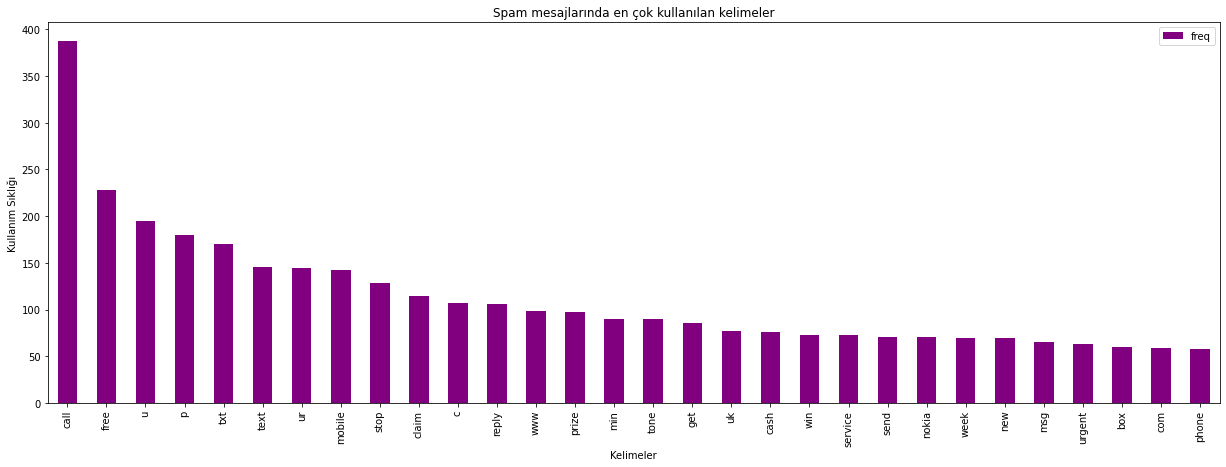

In [35]:
spam_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="purple");
plt.title('Spam mesajlarında en çok kullanılan kelimeler');
plt.xlabel('Kelimeler')
plt.ylabel('Kullanım Sıklığı');

## Word Cloud

In [36]:
spam_text = " ".join(i for i in (df[df['label']=="spam"]['text']))

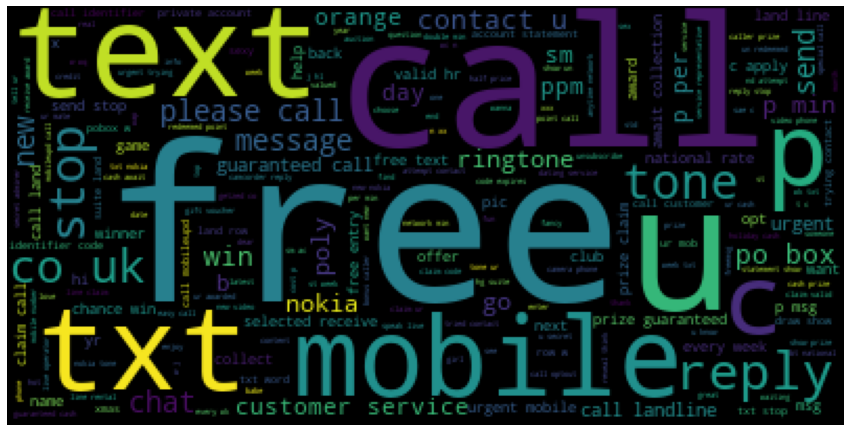

In [37]:
wordcloud = WordCloud(background_color= "black").generate(spam_text)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [38]:
ham_text = " ".join(i for i in (df[df['label']=="ham"]['text']))

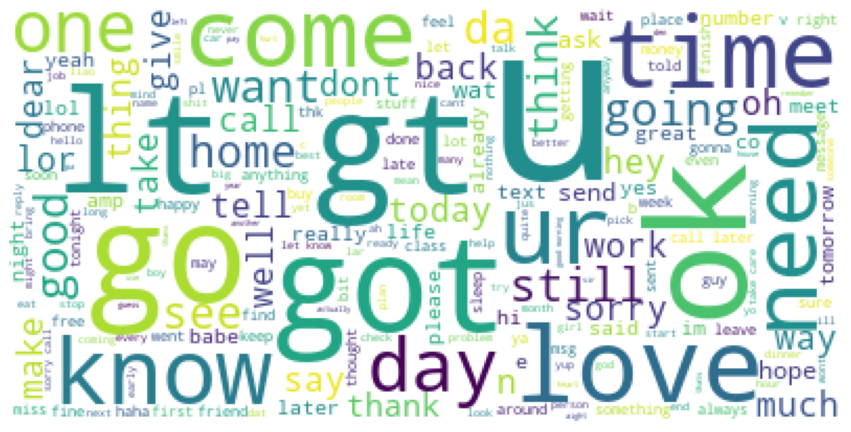

In [39]:
wordcloud = WordCloud(background_color= "white").generate(ham_text)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Degisken Muhendisligi

* Count Vectors
* TF-IDF Vectors (words, characters, n-grams)
* Word Embeddings

TF(t) = (Bir t teriminin bir dökümanda gözlenme frekansı) / (dökümandaki toplam terim sayısı) 

IDF(t) = log_e(Toplam döküman sayısı / içinde t terimi olan belge sayısı)

## Train - Test

In [40]:
X_train, X_test , y_train, y_test = model_selection.train_test_split(df["text"], df["label"], random_state=450)
X_train.head()

1954         eat shit wait ur monkey face bitch u asshole
121     urgent mobile awarded bonus caller prize final...
5021                   cool last little getting time soon
4718                             k addie amp art get home
4173                                     sorry call later
Name: text, dtype: object

In [41]:
encoder = preprocessing.LabelEncoder()

In [42]:
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [43]:
y_train[10:20], y_test[10:20]

(array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## Count Vectors

In [44]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

CountVectorizer()

In [45]:
x_train_count = vectorizer.transform(X_train)
x_test_count = vectorizer.transform(X_test)

In [46]:
vectorizer.get_feature_names()[:5]

['aa', 'aah', 'aaooooright', 'aathi', 'abdomen']

In [47]:
x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## TF- IDF

### Word Level TF-IDF

In [48]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(X_train)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(X_train)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test)

In [49]:
tf_idf_word_vectorizer.get_feature_names()[:5]

['aa', 'aah', 'aaooooright', 'aathi', 'abdomen']

### Ngram Level TF-IDF

In [50]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
tf_idf_ngram_vectorizer.fit(X_train)
x_train_tf_idf_ngarm = tf_idf_ngram_vectorizer.transform(X_train)
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(X_test)

In [51]:
tf_idf_ngram_vectorizer.get_feature_names()[:5]

['aa exhaust',
 'aa exhaust hanging',
 'aah cuddle',
 'aah cuddle would',
 'aaooooright work']

### Characters level TF-IDF

In [52]:
tf_idf_chars_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = (2,3))
tf_idf_chars_vectorizer.fit(X_train)
x_train_tf_idf_chars = tf_idf_chars_vectorizer.transform(X_train)
x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(X_test)

In [53]:
tf_idf_chars_vectorizer.get_feature_names()[:5]

[' a', ' aa', ' ab', ' ac', ' ad']

# Model Oluşturma 

In [54]:
all_performances = pd.DataFrame()
list_clf_name = []
list_x_test = []
list_pred = []
list_model = []

In [55]:
def fit_model(model, x_train_x, y_train):
    x_model = model.fit(x_train_x,y_train)
    return x_model

In [56]:
def model_name(model, vector_name):
    model_name= model.__class__.__name__
    if vector_name == "c":
        return model_name+"_count"
    elif vector_name == "n":
        return model_name+"_ngram"
    elif vector_name == "w":
        return model_name+"_word"
    elif vector_name == "ch":
        return model_name+"_chars"
    else:
        return

In [57]:
def add_list(name, model, x_test_x, y_pred):
    global list_clf_name, list_pred, list_model, list_x_test
    list_clf_name.append(name)
    list_model.append(model)
    list_x_test.append(x_test_x)
    list_pred.append(y_pred)

In [58]:
def add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC):
    global all_performances
    models = pd.DataFrame([[name, training_set_score, test_set_score, precision, recall, f1_score, AUC]],
                         columns=["model_name","training_set_score", "test_set_score",
                                  "precision", "recall", "f1_score", "AUC"])
    all_performances = all_performances.append(models, ignore_index=True)
    all_performances= all_performances.drop_duplicates()
    

In [59]:
def model_performance(x_train_x, x_test_x, model, vector_name):
    
    x_model = fit_model(model, x_train_x, y_train)
    
    name = model_name(model, vector_name)
    y_pred = x_model.predict(x_test_x)
    training_set_score= x_model.score(x_train_x, y_train)
    test_set_score = x_model.score(x_test_x, y_test)
    precision = mt.precision_score(y_test,y_pred)
    recall = mt.recall_score(y_test,y_pred)
    f1_score= mt.f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred) 
    
    add_list(name, model, x_test_x, y_pred)
    add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC)
    
    print(classification_report(y_test, y_pred, target_names=['spam', 'ham']))

## Logistic Regression

In [60]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_count, x_test_count, log_reg, "c")

              precision    recall  f1-score   support

        spam       0.98      1.00      0.99      1199
         ham       0.99      0.87      0.93       195

    accuracy                           0.98      1394
   macro avg       0.99      0.94      0.96      1394
weighted avg       0.98      0.98      0.98      1394



In [61]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, log_reg, "w")

              precision    recall  f1-score   support

        spam       0.96      1.00      0.98      1199
         ham       0.97      0.73      0.83       195

    accuracy                           0.96      1394
   macro avg       0.96      0.86      0.90      1394
weighted avg       0.96      0.96      0.96      1394



In [62]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, log_reg, "n")

              precision    recall  f1-score   support

        spam       0.89      1.00      0.94      1199
         ham       1.00      0.21      0.34       195

    accuracy                           0.89      1394
   macro avg       0.94      0.60      0.64      1394
weighted avg       0.90      0.89      0.86      1394



In [63]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, log_reg, "ch")

              precision    recall  f1-score   support

        spam       0.97      1.00      0.98      1199
         ham       0.99      0.78      0.87       195

    accuracy                           0.97      1394
   macro avg       0.98      0.89      0.93      1394
weighted avg       0.97      0.97      0.97      1394



## Naive Bayes

In [64]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_count, x_test_count, nb, "c")

              precision    recall  f1-score   support

        spam       0.99      0.99      0.99      1199
         ham       0.94      0.94      0.94       195

    accuracy                           0.98      1394
   macro avg       0.97      0.97      0.97      1394
weighted avg       0.98      0.98      0.98      1394



In [65]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, nb, "w")

              precision    recall  f1-score   support

        spam       0.96      1.00      0.98      1199
         ham       0.99      0.76      0.86       195

    accuracy                           0.97      1394
   macro avg       0.98      0.88      0.92      1394
weighted avg       0.97      0.97      0.96      1394



In [66]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, nb, "n")

              precision    recall  f1-score   support

        spam       0.93      1.00      0.97      1199
         ham       1.00      0.56      0.72       195

    accuracy                           0.94      1394
   macro avg       0.97      0.78      0.84      1394
weighted avg       0.94      0.94      0.93      1394



In [67]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, nb, "ch")

              precision    recall  f1-score   support

        spam       0.93      1.00      0.96      1199
         ham       1.00      0.53      0.69       195

    accuracy                           0.93      1394
   macro avg       0.96      0.76      0.83      1394
weighted avg       0.94      0.93      0.93      1394



## Random Forests

In [68]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_count, x_test_count, rf, "c")

              precision    recall  f1-score   support

        spam       0.97      1.00      0.98      1199
         ham       0.98      0.83      0.90       195

    accuracy                           0.97      1394
   macro avg       0.98      0.91      0.94      1394
weighted avg       0.97      0.97      0.97      1394



In [69]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, rf, "w")

              precision    recall  f1-score   support

        spam       0.97      1.00      0.98      1199
         ham       0.98      0.83      0.90       195

    accuracy                           0.97      1394
   macro avg       0.98      0.91      0.94      1394
weighted avg       0.97      0.97      0.97      1394



In [70]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, rf, "n")

              precision    recall  f1-score   support

        spam       0.95      1.00      0.97      1199
         ham       1.00      0.67      0.80       195

    accuracy                           0.95      1394
   macro avg       0.97      0.83      0.89      1394
weighted avg       0.96      0.95      0.95      1394



In [71]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, rf, "ch")

              precision    recall  f1-score   support

        spam       0.97      1.00      0.99      1199
         ham       1.00      0.83      0.90       195

    accuracy                           0.98      1394
   macro avg       0.99      0.91      0.95      1394
weighted avg       0.98      0.98      0.97      1394



## XGBoost

In [72]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_count, x_test_count, xgb, "c")

[07:03:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        spam       0.98      0.99      0.99      1199
         ham       0.96      0.90      0.93       195

    accuracy                           0.98      1394
   macro avg       0.97      0.95      0.96      1394
weighted avg       0.98      0.98      0.98      1394



In [73]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, xgb, "w")

[07:03:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        spam       0.98      1.00      0.99      1199
         ham       0.98      0.85      0.91       195

    accuracy                           0.98      1394
   macro avg       0.98      0.92      0.95      1394
weighted avg       0.98      0.98      0.98      1394



In [74]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, xgb, "n")

[07:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        spam       0.93      1.00      0.96      1199
         ham       1.00      0.54      0.70       195

    accuracy                           0.94      1394
   macro avg       0.97      0.77      0.83      1394
weighted avg       0.94      0.94      0.93      1394



In [75]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, xgb, "ch")

#print("Char Level TF-IDF Accuracy: ", accuracy)

[07:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        spam       0.98      1.00      0.99      1199
         ham       0.99      0.88      0.93       195

    accuracy                           0.98      1394
   macro avg       0.99      0.94      0.96      1394
weighted avg       0.98      0.98      0.98      1394



## SVC

In [76]:
svc = svm.SVC()
model_performance(x_train_count, x_test_count, svc, "c")

              precision    recall  f1-score   support

        spam       0.98      1.00      0.99      1199
         ham       0.99      0.86      0.92       195

    accuracy                           0.98      1394
   macro avg       0.99      0.93      0.96      1394
weighted avg       0.98      0.98      0.98      1394



In [77]:
svc = svm.SVC()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, svc, "w")

              precision    recall  f1-score   support

        spam       0.98      1.00      0.99      1199
         ham       0.98      0.88      0.93       195

    accuracy                           0.98      1394
   macro avg       0.98      0.94      0.96      1394
weighted avg       0.98      0.98      0.98      1394



In [78]:
svc = svm.SVC()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, svc, "n")

              precision    recall  f1-score   support

        spam       0.94      1.00      0.97      1199
         ham       1.00      0.59      0.74       195

    accuracy                           0.94      1394
   macro avg       0.97      0.79      0.85      1394
weighted avg       0.95      0.94      0.94      1394



In [79]:
svc = svm.SVC()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, svc, "ch")

              precision    recall  f1-score   support

        spam       0.98      1.00      0.99      1199
         ham       1.00      0.87      0.93       195

    accuracy                           0.98      1394
   macro avg       0.99      0.94      0.96      1394
weighted avg       0.98      0.98      0.98      1394



## SGDClassifier

In [80]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_count, x_test_count, sgdc, "c")

              precision    recall  f1-score   support

        spam       0.98      0.99      0.99      1199
         ham       0.96      0.90      0.93       195

    accuracy                           0.98      1394
   macro avg       0.97      0.95      0.96      1394
weighted avg       0.98      0.98      0.98      1394



In [81]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, sgdc, "w")

              precision    recall  f1-score   support

        spam       0.99      1.00      0.99      1199
         ham       0.98      0.94      0.96       195

    accuracy                           0.99      1394
   macro avg       0.98      0.97      0.98      1394
weighted avg       0.99      0.99      0.99      1394



In [82]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, sgdc, "n")

              precision    recall  f1-score   support

        spam       0.96      1.00      0.98      1199
         ham       0.99      0.77      0.87       195

    accuracy                           0.97      1394
   macro avg       0.98      0.88      0.92      1394
weighted avg       0.97      0.97      0.97      1394



In [83]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, sgdc, "ch")

              precision    recall  f1-score   support

        spam       0.99      0.99      0.99      1199
         ham       0.96      0.94      0.95       195

    accuracy                           0.99      1394
   macro avg       0.98      0.97      0.97      1394
weighted avg       0.99      0.99      0.99      1394



# Performans Değerlendirmesi

In [84]:
def display_all_confusion_matrix():
    f, ax = plt.subplots(6, 4, figsize=(20,40), sharey='row')
    ax = ax.flatten()

    for i in range(len(list_clf_name)):
        cf_matrix = confusion_matrix(y_test, list_pred[i])
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=ax[i], xticks_rotation=45)
        disp.ax_.set_title(list_clf_name[i]+"\nAccuracy:{accuracy:.4f}\nAUC:{auc:.4f}"
                           .format(accuracy= accuracy_score(y_test, list_pred[i]),auc= roc_auc_score(y_test, list_pred[i])),
                             fontsize=14)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')


    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust()


    f.colorbar(disp.im_)
    plt.show()

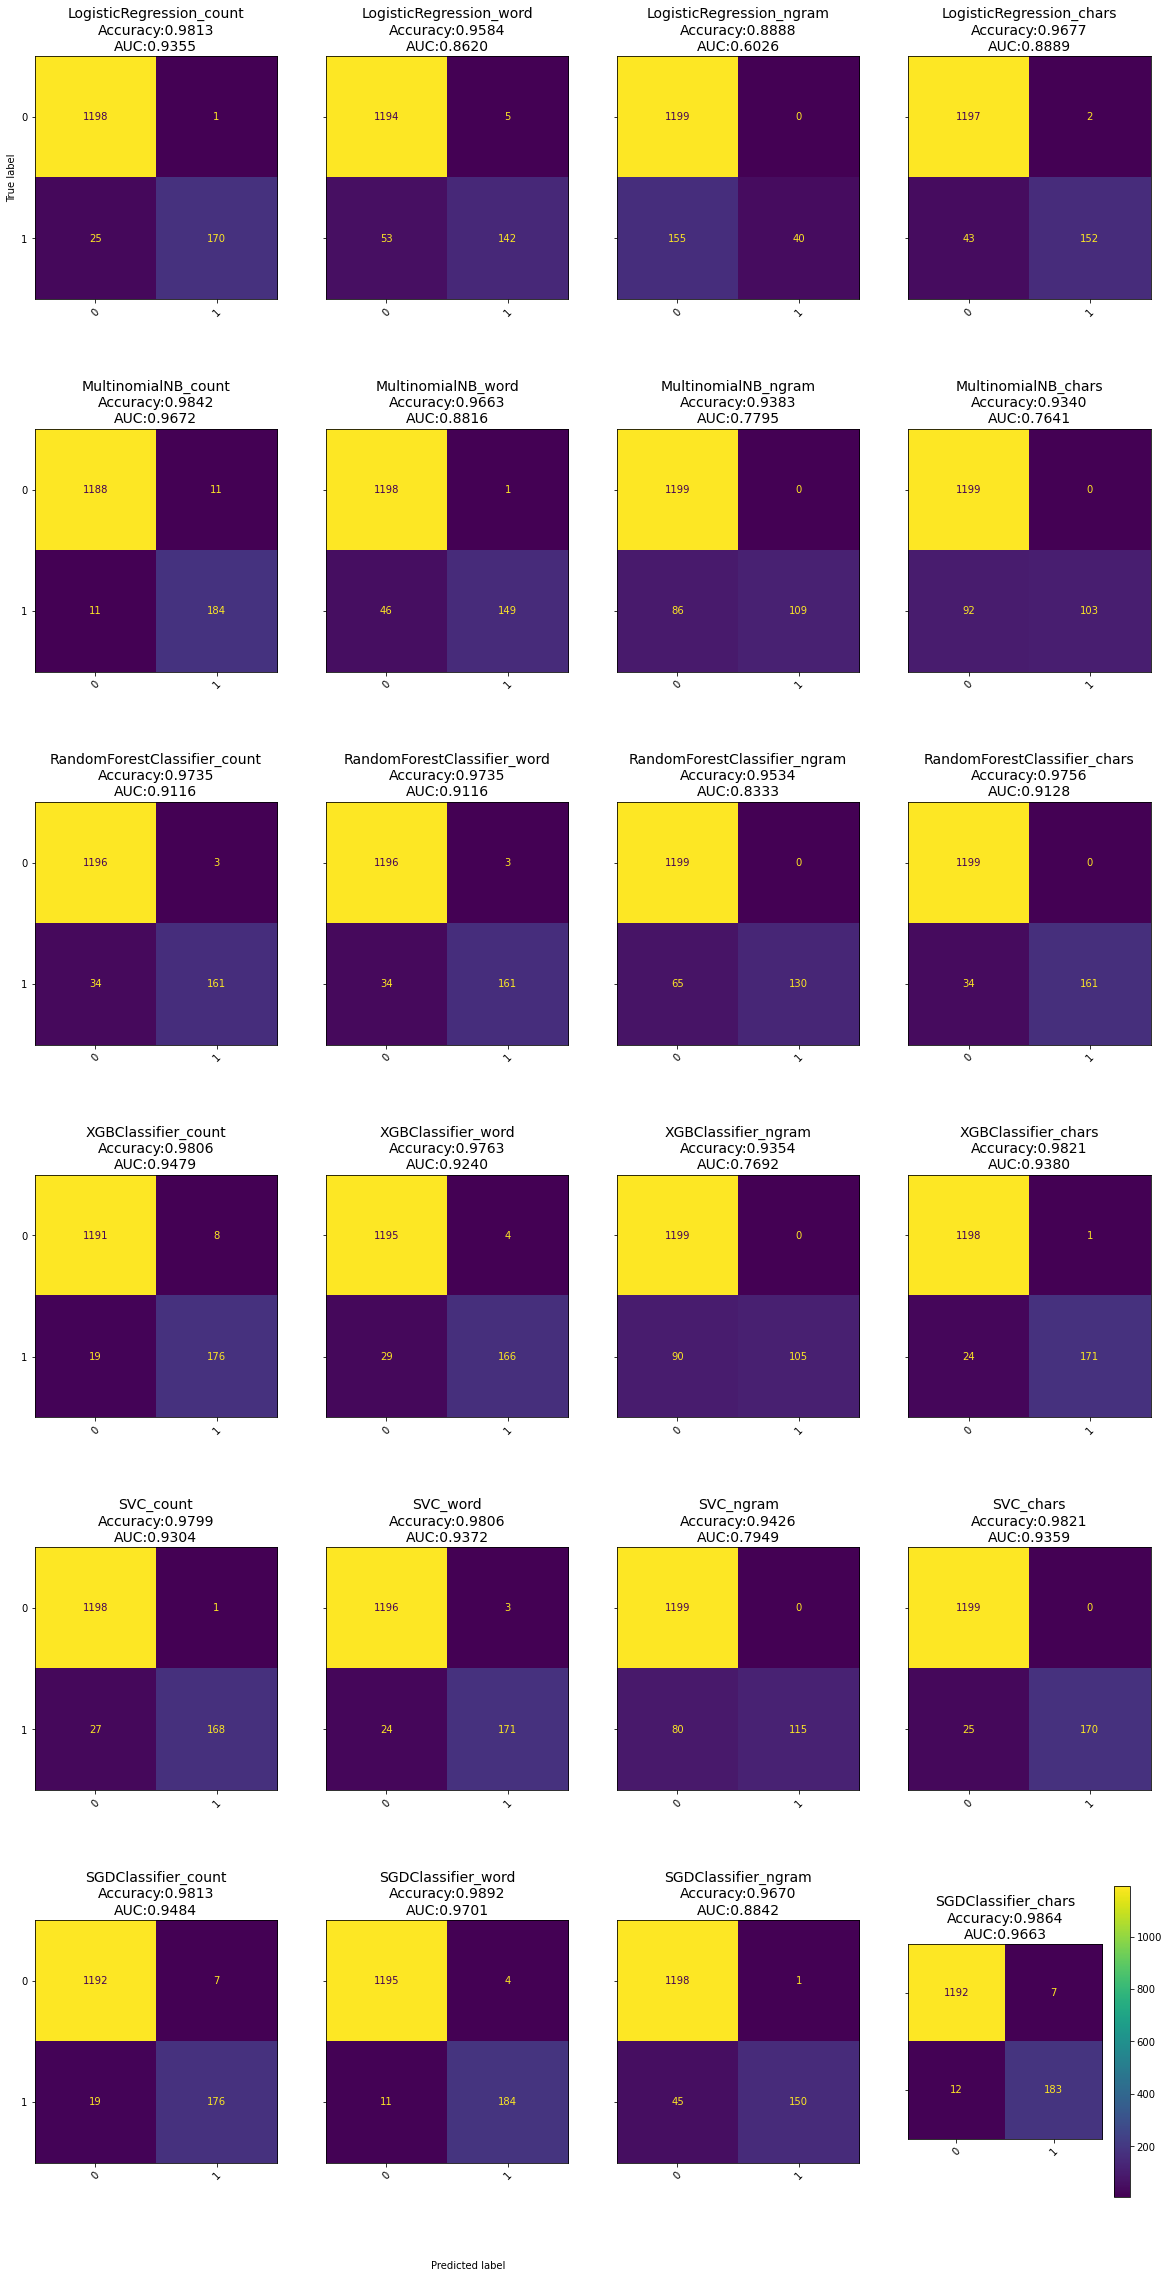

In [85]:
display_all_confusion_matrix()

In [86]:
all_performances.sort_values(by=['test_set_score'], ascending=False)

,model_name,training_set_score,test_set_score,precision,recall,f1_score,AUC
21,SGDClassifier_word,0.998565,0.989240,0.978723,0.943590,0.960836,0.970127
23,SGDClassifier_chars,0.997129,0.986370,0.963158,0.938462,0.950649,0.966312
4,MultinomialNB_count,0.991148,0.984218,0.943590,0.943590,0.943590,0.967208
15,XGBClassifier_chars,1.000000,0.982066,0.994186,0.876923,0.931880,0.938045
19,SVC_chars,0.996411,0.982066,1.000000,0.871795,0.931507,0.935897
20,SGDClassifier_count,0.999522,0.981349,0.961749,0.902564,0.931217,0.948363
0,LogisticRegression_count,0.994976,0.981349,0.994152,0.871795,0.928962,0.935480
12,XGBClassifier_count,0.991148,0.980631,0.956522,0.902564,0.928760,0.947946
17,SVC_word,0.997608,0.980631,0.982759,0.876923,0.926829,0.937210
16,SVC_count,0.995694,0.979914,0.994083,0.861538,0.923077,0.930352


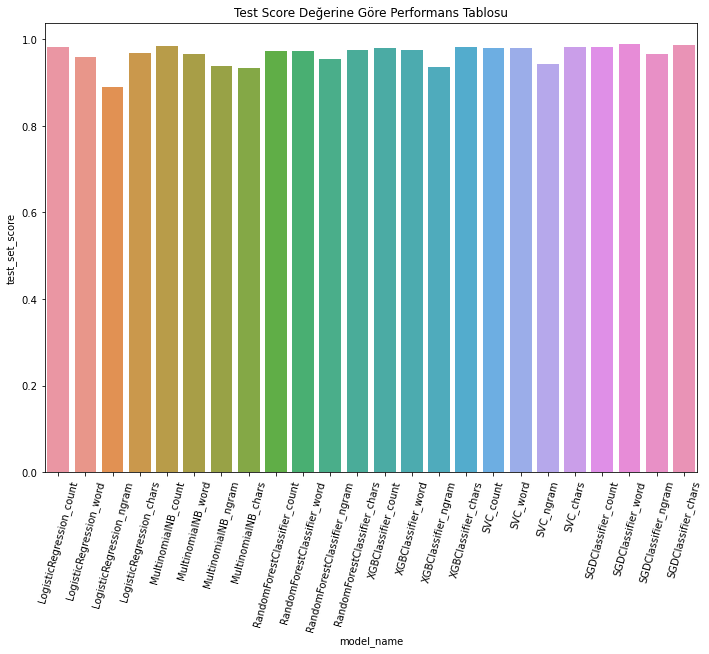

In [87]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=75)
sns.barplot(x="model_name", y ="test_set_score", data = all_performances, ax=ax);
title = plt.title('Test Score Değerine Göre Performans Tablosu')

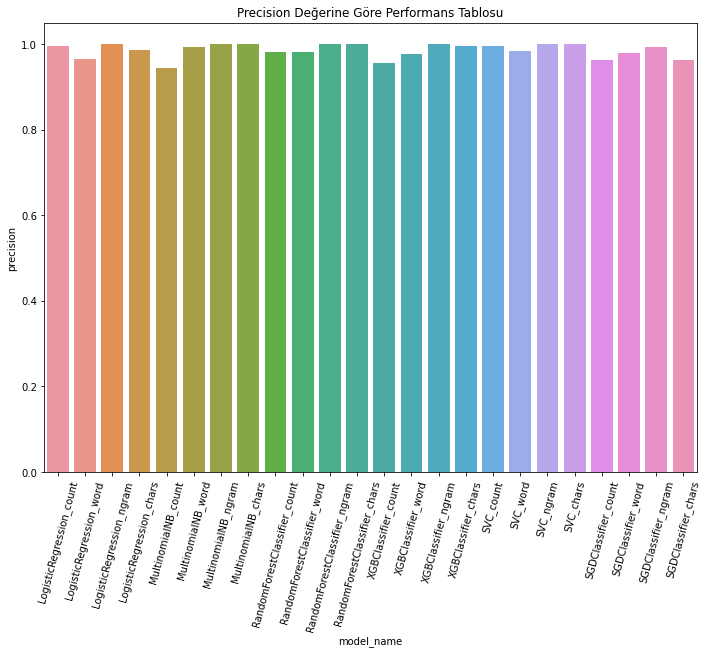

In [90]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=75)
sns.barplot(x="model_name", y ="precision", data = all_performances, ax=ax);
title = plt.title('Precision Değerine Göre Performans Tablosu')

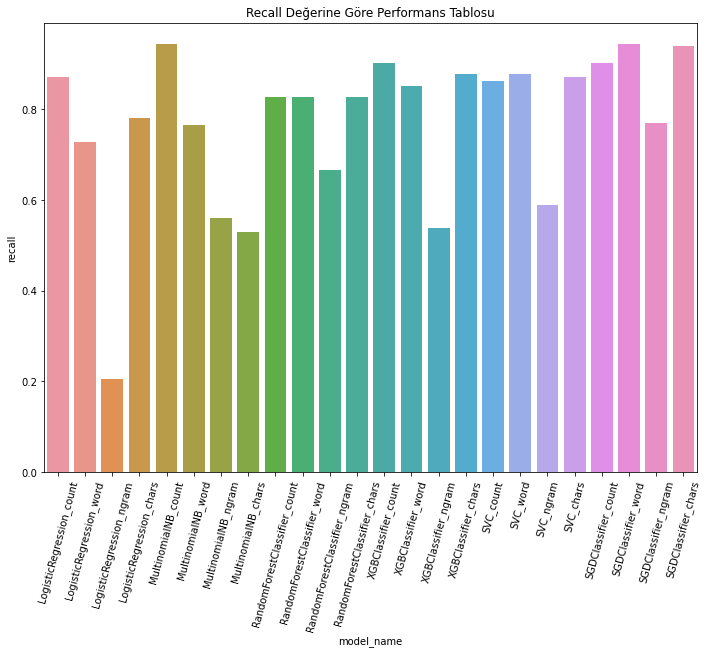

In [91]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=75)
sns.barplot(x="model_name", y ="recall", data = all_performances, ax=ax);
title = plt.title('Recall Değerine Göre Performans Tablosu')

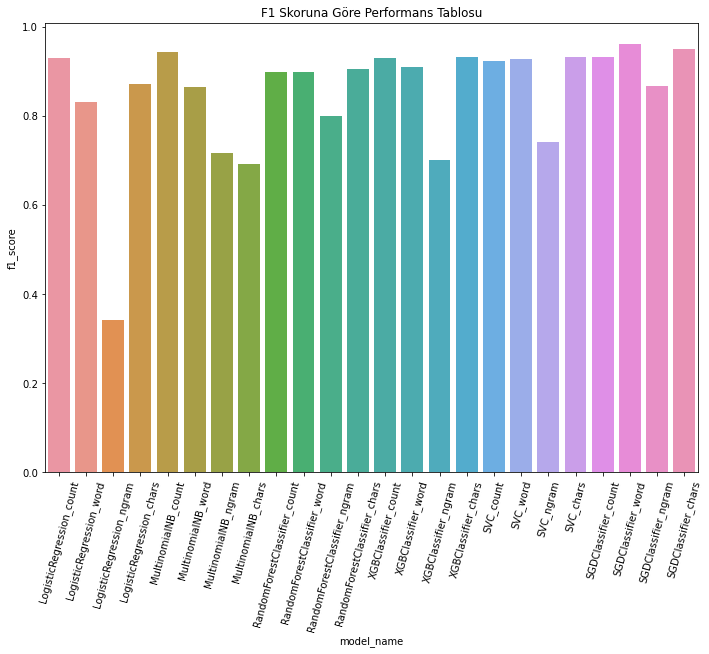

In [89]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=75)
sns.barplot(x="model_name", y ="f1_score", data = all_performances, ax=ax);
title = plt.title('F1 Skoruna Göre Performans Tablosu')

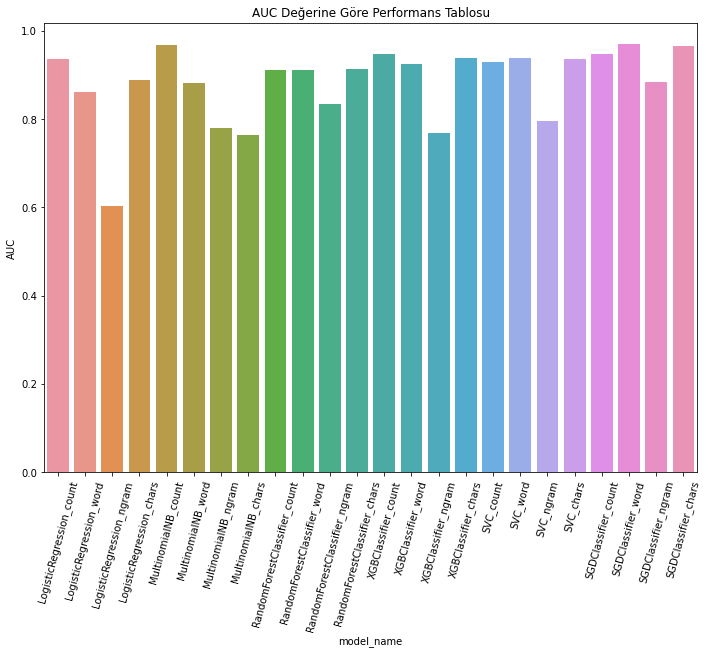

In [88]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=75)
sns.barplot(x="model_name", y ="AUC", data = all_performances, ax=ax);
title = plt.title('AUC Değerine Göre Performans Tablosu')